In [29]:
import numpy as np
import pandas as pd
from skimage import io

from glob import glob
from os import path
import seaborn as sb
import matplotlib.pyplot as plt

In [30]:
from functools import reduce
from twophotonUtils import parse_XML_timestamps
from skimage import draw

experiment_dirname = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG'
dx = 0.58 # microns per pixel
dz = 1


In [31]:
mice_dirs

['/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/M1 DOB 12-5-2025',
 '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F1 DOB 12-5-2025',
 '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F2 DOB 12-5-2025',
 '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/M2 DPB 12-5-2025']

In [32]:
glob(path.join(mice_dirs[2],'*R*'))


['/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F2 DOB 12-5-2025/Left paw R2',
 '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F2 DOB 12-5-2025/Left paw R3',
 '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F2 DOB 12-5-2025/Left paw R1']

In [56]:
manifest = []
# Parse filestructure
mice_dirs = glob(path.join(experiment_dirname,'*'))
timestamps = {}

for m in mice_dirs:
    mouse = path.split(m)[1]
    for r in glob(path.join(m,'*R*')):
        region = path.split(r)[1]
        print(r)
        
        timestamps[mouse+'_'+region] = parse_XML_timestamps(r)

        for c in glob(path.join(r,'Clones/*.csv')):
            clone = path.splitext(path.split(c)[1])[0]
            manifest.append({'Mouse':mouse,'Region':region,
                             'dirname':r,'filename':c,'Clone':clone,})
            # print(c)
        
manifest = pd.DataFrame(manifest)
manifest['Mouse_Region'] = manifest['Mouse'] + '_' + manifest['Region']
manifest['Mouse_Region'].unique()

/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/M1 DOB 12-5-2025/Left paw R2
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/M1 DOB 12-5-2025/Left paw R3
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/M1 DOB 12-5-2025/Left paw R1
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F1 DOB 12-5-2025/Left paw R2
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F1 DOB 12-5-2025/Left paw R3
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F1 DOB 12-5-2025/Left paw R1
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two photon/NMS/Dermal topography/01-26-2026 mTmG/F2 DOB 12-5-2025/Left paw R2
/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Two ph

array(['M1 DOB 12-5-2025_Left paw R2', 'M1 DOB 12-5-2025_Left paw R3',
       'M1 DOB 12-5-2025_Left paw R1', 'F1 DOB 12-5-2025_Left paw R2',
       'F1 DOB 12-5-2025_Left paw R3', 'F1 DOB 12-5-2025_Left paw R1',
       'F2 DOB 12-5-2025_Left paw R2', 'F2 DOB 12-5-2025_Left paw R3',
       'F2 DOB 12-5-2025_Left paw R1', 'M2 DPB 12-5-2025_Left paw R2',
       'M2 DPB 12-5-2025_Left paw R1'], dtype=object)

In [57]:
from measurements import get_bm_image
from collections import defaultdict
# Calculate the curvatures
overwrite = False

sigmas = [5/dz,5/dx,5/dx]

kwds = defaultdict(dict)
kwds[('M1 DOB 12-5-2025_Left paw R2',4)] = {'method':'maximum'}
kwds[('F1 DOB 12-5-2025_Left paw R1',3)] = {'method':'maximum'}
kwds[('F1 DOB 12-5-2025_Left paw R1',4)] = {'method':'maximum'}
kwds[('F2 DOB 12-5-2025_Left paw R3',0)] = {'method':'threshold', 'threshold':.9}

for m in mice_dirs:
    mouse = path.split(m)[1]
    for r in glob(path.join(m,'*R*')):
        region = path.split(r)[1]
        ID = f'{mouse} {region}'
        print(ID)
    
        if path.exists(path.join(r,'height_image.tif')) and not overwrite:
            continue
        else:
    
            # Calculate basement membranes
            B = io.imread(path.join(r,'B_align.tif'))
            bm = np.zeros_like(B)
            h = np.zeros((5,1024,1024))
            for t,this_day in enumerate(B):
                h[t,...],bm[t,...] = get_bm_image(this_day,sigmas=sigmas,gradient_sign=+1,
                                                          **kwds[(ID,t)])

            io.imsave(path.join(r,'heightmaps.tif'),h)
            io.imsave(path.join(r,'height_image.tif'),bm)
            

M1 DOB 12-5-2025 Left paw R2
M1 DOB 12-5-2025 Left paw R3
M1 DOB 12-5-2025 Left paw R1
F1 DOB 12-5-2025 Left paw R2
F1 DOB 12-5-2025 Left paw R3
F1 DOB 12-5-2025 Left paw R1
F2 DOB 12-5-2025 Left paw R2
F2 DOB 12-5-2025 Left paw R3
F2 DOB 12-5-2025 Left paw R1
M2 DPB 12-5-2025 Left paw R2
M2 DPB 12-5-2025 Left paw R1


In [35]:
# Manually put in reference frames

references = defaultdict(list)
references['M1 DOB 12-5-2025_Left paw R2'] = 1
references['M1 DOB 12-5-2025_Left paw R1'] = 1
references['F1 DOB 12-5-2025_Left paw R2'] = 1
references['F2 DOB 12-5-2025_Left paw R2'] = 1
references['F2 DOB 12-5-2025_Left paw R1'] = 2
references['M2 DOB 12-5-2025_Left paw R1'] = 1


In [43]:
manifest['Mouse_Region'].unique()

array(['M1 DOB 12-5-2025_Left paw R2', 'M1 DOB 12-5-2025_Left paw R3',
       'M1 DOB 12-5-2025_Left paw R1', 'F1 DOB 12-5-2025_Left paw R2',
       'F1 DOB 12-5-2025_Left paw R3', 'F1 DOB 12-5-2025_Left paw R1',
       'F2 DOB 12-5-2025_Left paw R2', 'F2 DOB 12-5-2025_Left paw R3',
       'F2 DOB 12-5-2025_Left paw R1', 'M2 DPB 12-5-2025_Left paw R2',
       'M2 DPB 12-5-2025_Left paw R1'], dtype=object)

In [44]:
# Calculate the 'reference curvature'
from measurements import get_mesh_from_bm_image, get_tissue_curvature_over_grid

curvatures = {}
for regionID,region in manifest.groupby(['Mouse_Region']):

    regionID = regionID[0]
    
    print(regionID)
    if path.exists(path.join(region.iloc[0]['dirname'],'reference_curvature.npz')):
        curvatures[regionID] = np.load(path.join(region.iloc[0]['dirname'],'reference_curvature.npz'))['reference_curvature']
    else:
    
        if references[regionID] == []:
            reference_frame = 0
        else:
            reference_frame = references[regionID]
    
        print((regionID, reference_frame))
        
        bm = io.imread(path.join(region.iloc[0]['dirname'],'height_image.tif'))[reference_frame]
        mesh = get_mesh_from_bm_image(bm,spacing=[dz,dx,dx],decimation_factor=60)
        meanC,gaussC = get_tissue_curvature_over_grid(mesh, bm.shape, spacing=[dz,dx,dx])
        curvatures[regionID] = meanC
    
        np.savez(path.join(region.iloc[0]['dirname'],'reference_curvature'),reference_curvature=meanC)
        

F1 DOB 12-5-2025_Left paw R1
F1 DOB 12-5-2025_Left paw R2
F1 DOB 12-5-2025_Left paw R3
F2 DOB 12-5-2025_Left paw R1
('F2 DOB 12-5-2025_Left paw R1', 2)
F2 DOB 12-5-2025_Left paw R2
F2 DOB 12-5-2025_Left paw R3
M1 DOB 12-5-2025_Left paw R1
M1 DOB 12-5-2025_Left paw R2
M1 DOB 12-5-2025_Left paw R3
M2 DPB 12-5-2025_Left paw R1
M2 DPB 12-5-2025_Left paw R2


In [45]:
curvatures

{'F1 DOB 12-5-2025_Left paw R1': array([[ 1.0773827 ,  1.0773827 ,  1.0773827 , ...,  1.48411664,
          1.48411664,  1.48411664],
        [ 1.0773827 ,  1.0773827 ,  1.0773827 , ...,  1.48411664,
          1.48411664,  1.48411664],
        [ 0.75      ,  1.0773827 ,  1.0773827 , ...,  1.48411664,
          1.48411664,  1.48411664],
        ...,
        [-1.48410417, -1.48410417, -0.75002   , ..., -0.96283181,
         -0.96283181, -0.96283181],
        [-1.48410417, -0.75002   , -0.75002   , ..., -0.96283181,
         -0.96283181, -0.96283181],
        [-0.75002   , -0.75002   , -0.75002   , ..., -0.96283181,
         -0.96283181, -0.96283181]]),
 'F1 DOB 12-5-2025_Left paw R2': array([[ 1.43584771,  1.43584771,  1.43584771, ...,  0.96314387,
          0.96314387,  0.96314387],
        [ 1.43584771,  1.43584771,  1.43584771, ...,  0.96314387,
          0.96314387,  0.96314387],
        [ 1.13743595,  1.43584771,  1.43584771, ...,  0.96314387,
          0.96314387,  0.96314387],
   

In [126]:
from skimage import draw

polys = {}
masks = {}
for regionID,region in manifest.groupby('Mouse_Region'):
    regionID = regionID
    polys[regionID] = pd.read_csv(path.join(region.iloc[0]['dirname'],'mask.csv'))
    masks[regionID] = draw.polygon2mask([1024,1024],polys[regionID][['axis-0','axis-1']])
len(list(masks.keys()))

11

In [173]:
# Load the clones .csvs

raw_clones = []
for idx,c in manifest.iterrows():
    data = pd.read_csv(c['filename'],index_col=0)
    data = data.rename(columns={'axis-0':'Frame','axis-1':'Z','axis-2':'Y','axis-3':'X'})
    raw_clones.append(data)

# Parse clone # and QC for clone physical distance (should be small)
clone_counts = []
for i,clone in enumerate(raw_clones):
    this_count = pd.merge(clone.groupby('Frame').mean()[['Z','Y','X']].reset_index(drop=True),
                          clone.groupby('Frame').count().reset_index()[['Frame','Z']].rename(columns={'Z':'Count'}),
                          left_index=True,right_index=True)
    this_count[['Mouse','Region','Clone','Mouse_Region']] = \
        manifest.iloc[i][['Mouse','Region','Clone','Mouse_Region']]
    refT = references[manifest.iloc[i]['Mouse_Region']]
    if refT == []:
        refT = 0
    
    this_count['reference'] = refT
    clone_counts.append(this_count)

clone_counts = pd.concat(clone_counts,ignore_index=True)
clone_counts['UniqueID'] = clone_counts['Mouse'] + '_' + clone_counts['Region'] + '_' + clone_counts['Clone']


In [174]:
clone_counts.set_index('Mouse_Region').loc['F2 DOB 12-5-2025_Left paw R3']

,Z,Y,X,Frame,Count,Mouse,Region,Clone,reference,UniqueID
Mouse_Region,,,,,,,,,,
F2 DOB 12-5-2025_Left paw R3,69.0,311.524409,51.804201,0.0,1,F2 DOB 12-5-2025,Left paw R3,Clone9,0,F2 DOB 12-5-2025_Left paw R3_Clone9
F2 DOB 12-5-2025_Left paw R3,49.0,282.693832,47.107084,3.0,2,F2 DOB 12-5-2025,Left paw R3,Clone9,0,F2 DOB 12-5-2025_Left paw R3_Clone9
F2 DOB 12-5-2025_Left paw R3,58.0,306.822836,459.939037,0.0,1,F2 DOB 12-5-2025,Left paw R3,Clone8,0,F2 DOB 12-5-2025_Left paw R3_Clone8
F2 DOB 12-5-2025_Left paw R3,59.0,288.102491,474.370089,3.0,2,F2 DOB 12-5-2025,Left paw R3,Clone8,0,F2 DOB 12-5-2025_Left paw R3_Clone8
F2 DOB 12-5-2025_Left paw R3,48.0,283.338285,497.643873,4.0,3,F2 DOB 12-5-2025,Left paw R3,Clone8,0,F2 DOB 12-5-2025_Left paw R3_Clone8
F2 DOB 12-5-2025_Left paw R3,65.0,609.205202,139.006406,0.0,3,F2 DOB 12-5-2025,Left paw R3,Clone5,0,F2 DOB 12-5-2025_Left paw R3_Clone5
F2 DOB 12-5-2025_Left paw R3,47.5,594.039972,138.907646,3.0,4,F2 DOB 12-5-2025,Left paw R3,Clone5,0,F2 DOB 12-5-2025_Left paw R3_Clone5
F2 DOB 12-5-2025_Left paw R3,52.0,589.997057,133.427371,4.0,4,F2 DOB 12-5-2025,Left paw R3,Clone5,0,F2 DOB 12-5-2025_Left paw R3_Clone5
F2 DOB 12-5-2025_Left paw R3,60.0,661.404982,422.114064,0.0,1,F2 DOB 12-5-2025,Left paw R3,Clone4,0,F2 DOB 12-5-2025_Left paw R3_Clone4


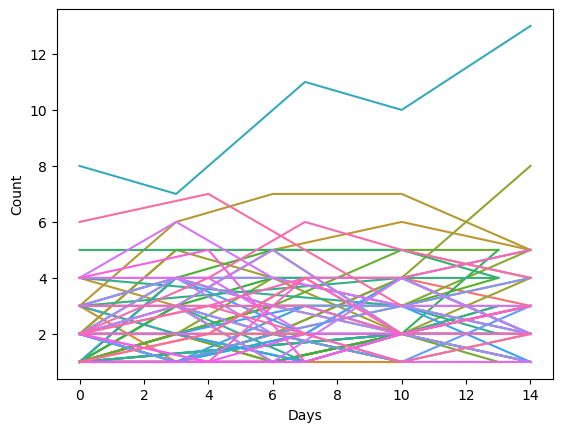

In [175]:
# Parse time stamps into delta times

# timestamps
df = []
for ID,clone in clone_counts.groupby('UniqueID'):
    ts = timestamps[clone.iloc[0]['Mouse_Region']]
    ts = [t - ts[0] for t in ts.values()]
    clone['Days'] = [ts[int(t)].days for t in clone['Frame']]
    df.append(clone)
    
df = pd.concat(df,ignore_index=True)

g = sb.lineplot(df,x='Days',y='Count',hue='UniqueID',legend=False)
# sb.move_legend(g,(0,1))

In [176]:
clone

,Z,Y,X,Frame,Count,Mouse,Region,Clone,Mouse_Region,reference,UniqueID,Days
317,66.0,128.370061,592.317710,0.0,1,M2 DPB 12-5-2025,Left paw R2,Clone9,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone9,0
318,64.0,197.729683,524.494213,1.0,2,M2 DPB 12-5-2025,Left paw R2,Clone9,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone9,4
319,57.0,144.682917,485.186177,2.0,2,M2 DPB 12-5-2025,Left paw R2,Clone9,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone9,7


In [177]:
# Parse final clone size change from initial size
counted = []
for i,clone in df.groupby('UniqueID'):
    if len(clone) < 2:
        size = -1
    else:
        size = clone.iloc[-1]['Count'] - clone.iloc[0]['Count']
    clone['Initial size'] = clone.iloc[0]['Count']
    clone['Final size'] = size
    clone['Extinction time'] = clone.iloc[-1]['Days']
    
    counted.append(clone)

df = pd.concat(counted,ignore_index=True)
# df

In [179]:
# Load tissue curvatures

df_curv = []
for i,clone in df.groupby('UniqueID'):

    ref = int(clone.iloc[0]['reference'])
    
    if ref in clone.set_index('Frame').index:
        Z,Y,X = clone.set_index('Frame').loc[ref][['Z','Y','X']].astype(int)
        C = curvatures[clone.iloc[0]['Mouse_Region']].copy()
        mask = masks[clone.iloc[0]['Mouse_Region']]
        C[~mask] = np.nan
        initC = np.nanmean(C[Y,X])
    else:
        initC = np.nan
        
    clone['Initial curvature'] = initC
    df_curv.append(clone)
    
df = pd.concat(df_curv,ignore_index=True)

/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice
  initC = np.nanmean(C[Y,X])
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_21884/159226694.py:13: RuntimeWarning: Mean of empty slice


In [187]:
pd.DataFrame([c.iloc[0] for _,c in df.groupby('UniqueID')])

,Z,Y,X,Frame,Count,Mouse,Region,Clone,Mouse_Region,reference,UniqueID,Days,Initial size,Final size,Extinction time,Initial curvature
0,58.0,767.901095,445.712444,0.0,1,F1 DOB 12-5-2025,Left paw R1,Clone1,F1 DOB 12-5-2025_Left paw R1,0,F1 DOB 12-5-2025_Left paw R1_Clone1,0,1,0,3,0.095587
2,59.0,827.726097,596.548168,0.0,2,F1 DOB 12-5-2025,Left paw R1,Clone2,F1 DOB 12-5-2025_Left paw R1,0,F1 DOB 12-5-2025_Left paw R1_Clone2,0,2,-1,6,-0.256195
5,57.0,796.211668,719.237932,0.0,1,F1 DOB 12-5-2025,Left paw R1,Clone3,F1 DOB 12-5-2025_Left paw R1,0,F1 DOB 12-5-2025_Left paw R1_Clone3,0,1,0,14,-0.014977
10,60.0,835.039496,915.012710,0.0,1,F1 DOB 12-5-2025,Left paw R1,Clone4,F1 DOB 12-5-2025_Left paw R1,0,F1 DOB 12-5-2025_Left paw R1_Clone4,0,1,2,14,-0.138047
15,59.0,366.361938,936.041474,0.0,3,F1 DOB 12-5-2025,Left paw R1,Clone5,F1 DOB 12-5-2025_Left paw R1,0,F1 DOB 12-5-2025_Left paw R1_Clone5,0,3,0,10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,61.0,712.193860,531.039177,0.0,2,M2 DPB 12-5-2025,Left paw R2,Clone5,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone5,0,2,0,14,-0.123392
375,64.0,321.554240,872.827160,0.0,1,M2 DPB 12-5-2025,Left paw R2,Clone6,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone6,0,1,-1,0,0.133137
376,59.0,356.642388,616.315095,0.0,6,M2 DPB 12-5-2025,Left paw R2,Clone7,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone7,0,6,-3,10,-0.116181
380,58.0,224.763251,587.408035,0.0,1,M2 DPB 12-5-2025,Left paw R2,Clone8,M2 DPB 12-5-2025_Left paw R2,0,M2 DPB 12-5-2025_Left paw R2_Clone8,0,1,3,7,0.064609


In [213]:
from basicUtils import nonan_pairs
from scipy.stats import pearsonr
X,Y = nonan_pairs(df['Initial curvature'],df['Final size'])
R = pearsonr(X,Y)
R

PearsonRResult(statistic=np.float64(0.20046258987301893), pvalue=np.float64(0.00027588364438551515))

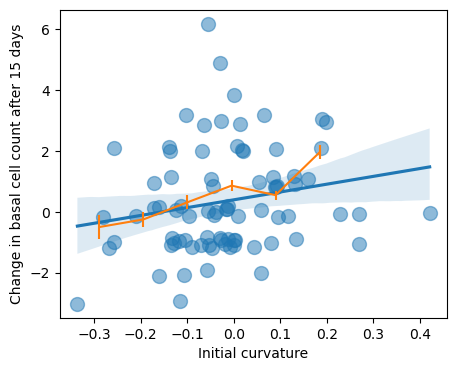

In [206]:
from basicUtils import plot_bin_means
unique = [c.iloc[0] for _,c in df.groupby('UniqueID')]
unique = pd.DataFrame(unique)

fig = plt.figure(figsize=[5,4])
sb.regplot(unique,x='Initial curvature',y='Final size',y_jitter=0.2, scatter_kws={'alpha':0.5,'s':100})
plot_bin_means(df['Initial curvature'],df['Final size'],bin_edges=9,mean='mean')
plt.ylabel('Change in basal cell count after 15 days')

fig.savefig(path.join(experiment_dirname,'Figures/curvature_v_size_change.svg'))

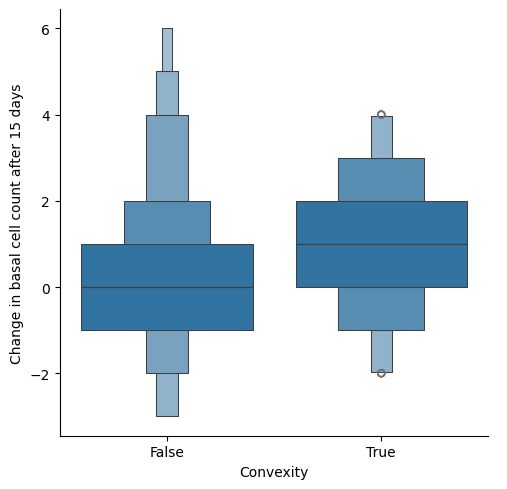

In [200]:
df['Convexity'] = df['Initial curvature'] > 0
sb.catplot(df,x='Convexity',y='Final size',kind='boxen')
plt.ylabel('Change in basal cell count after 15 days')

plt.savefig(path.join(experiment_dirname,'Figures/convexity_v_size_change.svg'))